<a href="https://colab.research.google.com/github/HetalA/Machine-Learning/blob/main/phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('dataset_phishing.csv')
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [ ]:
#Encoding 'status' as label 1 & 0 , naming the field as target
data['target'] = pd.get_dummies(data['status'])['legitimate'].astype('int')
data.drop('status',axis = 1, inplace=True)
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,target
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,0
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,1
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


In [ ]:
tmp = data.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]

,index,missing_val


No missing values!

In [ ]:
likely_cat = {}
for var in data.iloc[:,1:].columns:
    likely_cat[var] = 1.*data[var].nunique()/data[var].count() < 0.002 

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)

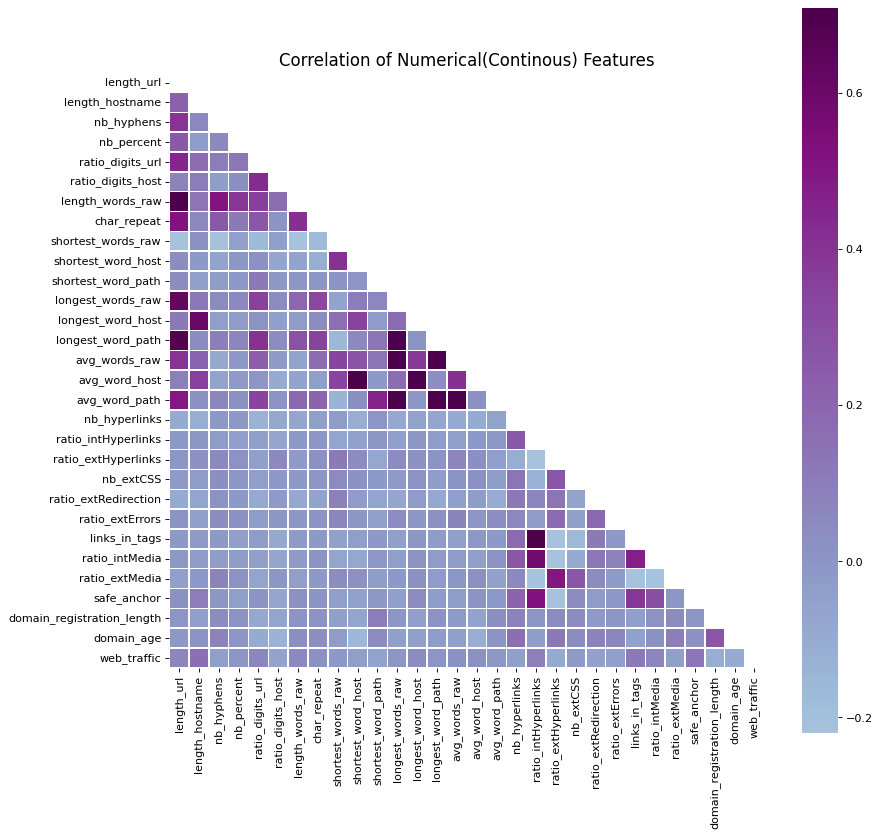

In [ ]:
#Taking all columns except URL 
corr = data[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0, square=True, linewidths=.5)
plt.title('Correlation of Numerical(Continous) Features', fontsize=15)
plt.show()

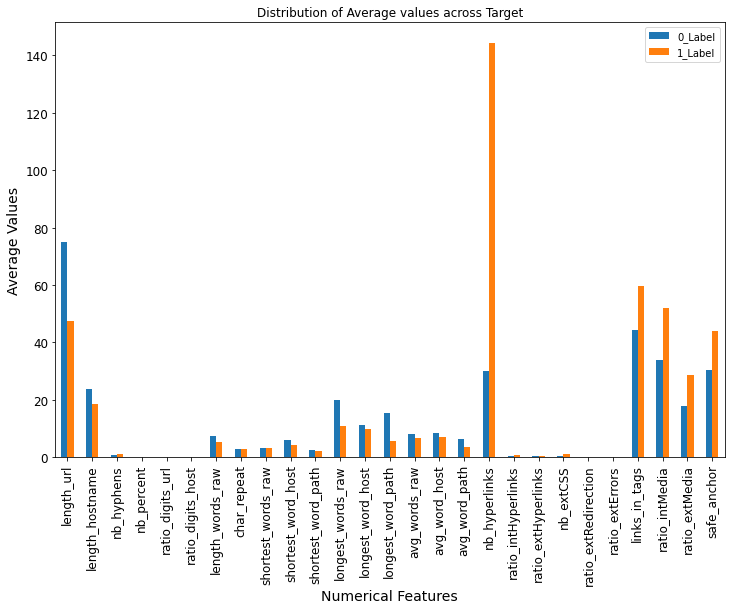

In [ ]:
distr =data.groupby('target')[num_cols].mean().reset_index().T
distr.rename(columns={0:'0_Label',1:"1_Label"}, inplace=True)

plt.rcParams['axes.facecolor']='w'
ax = distr[1:-3][['0_Label','1_Label']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Numerical Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)
plt.show()



1.   length_words_raw is expected to be highly correlated with length_url 
2.   Higher the length of URL ,or words in URL then more likely to be Phishing URL
3.   Higher nb_links implies Legitimate URL
4.   links_in_tags ,safe_anchor higher volume signals more towards Legitmate site





/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


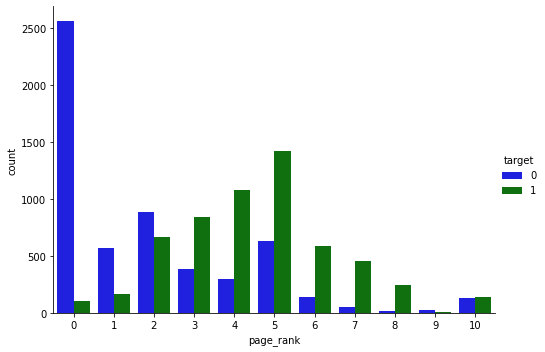

In [ ]:
sns.catplot("page_rank", hue="target", data=data, kind="count", palette={1:"green", 0:"blue"} ,height=5.0, aspect=11.7/8.27 )

In [ ]:
from sklearn.model_selection import train_test_split
X = data.iloc[: , 1:-1]
y = data['target']

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)
X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
input_shape = [X_train[1].shape]
print("Input shape is ", input_shape)

Input shape is  [(87, 1)]


In [ ]:
X_train.shape

(8572, 87, 1)

In [ ]:
X_train

array([[[ 81.],
        [ 27.],
        [  1.],
        ...,
        [  0.],
        [  1.],
        [  2.]],

       [[261.],
        [212.],
        [  0.],
        ...,
        [  0.],
        [  1.],
        [  4.]],

       [[ 24.],
        [ 15.],
        [  0.],
        ...,
        [  0.],
        [  0.],
        [  3.]],

       ...,

       [[ 58.],
        [ 22.],
        [  0.],
        ...,
        [  0.],
        [  1.],
        [  1.]],

       [[105.],
        [ 32.],
        [  0.],
        ...,
        [  0.],
        [  1.],
        [  0.]],

       [[ 82.],
        [ 16.],
        [  0.],
        ...,
        [  0.],
        [  1.],
        [ 10.]]])

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_valid).float()
ytest_tensor =  torch.from_numpy(y_valid.values.ravel()).float()

In [ ]:
batchsize = 64
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_dl = DataLoader(train_ds, batch_size=batchsize)

In [ ]:
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [ ]:
n_input_dim = X_train.shape[1]
n_hidden1 = 300  
n_hidden2 = 100
n_output =  1  
print(n_input_dim)

87


In [ ]:
class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        return x

In [ ]:
model_1 = ChurnModel()
print(model_1)

ChurnModel(
  (layer_1): Linear(in_features=87, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
loss_func = nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
epochs = 50

In [ ]:
from tensorflow import keras
model_1 = keras.Sequential([
    layers.Flatten(input_shape=(87,1)),
    layers.Dense(256, activation='relu'),  
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(10, activation='sigmoid'),  
])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 87)                0         
                                                                 
 dense (Dense)               (None, 256)               22528     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0

In [ ]:
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_1.fit(X_train, y_train, epochs=50, 
          batch_size=2000, 
          validation_split=0.2)
history

Epoch 1/50
4/4 [==============================] - 1s 100ms/step - loss: 2.6908 - accuracy: 0.2260 - val_loss: 8.8640 - val_accuracy: 0.0227
Epoch 2/50
4/4 [==============================] - 0s 36ms/step - loss: 2.0208 - accuracy: 0.4929 - val_loss: 4.9371 - val_accuracy: 0.1860
Epoch 3/50
4/4 [==============================] - 0s 35ms/step - loss: 1.7245 - accuracy: 0.6586 - val_loss: 3.6933 - val_accuracy: 0.2956
Epoch 4/50
4/4 [==============================] - 0s 38ms/step - loss: 1.5149 - accuracy: 0.7478 - val_loss: 2.9649 - val_accuracy: 0.4105
Epoch 5/50
4/4 [==============================] - 0s 40ms/step - loss: 1.3834 - accuracy: 0.7597 - val_loss: 2.6071 - val_accuracy: 0.4816
Epoch 6/50
4/4 [==============================] - 0s 36ms/step - loss: 1.2822 - accuracy: 0.7779 - val_loss: 2.4902 - val_accuracy: 0.5563
Epoch 7/50
4/4 [==============================] - 0s 38ms/step - loss: 1.1887 - accuracy: 0.7764 - val_loss: 2.1865 - val_accuracy: 0.5843
Epoch 8/50
4/4 [==========

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1)
    model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)
    results = model_1.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model_1.evaluate(val_x, val_y))
    return results

In [ ]:
n_folds=5
epochs=20
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
47/55 [========================>.....] - ETA: 0s - loss: 0.3637 - accuracy: 0.8263
Epoch 1: val_loss improved from inf to 0.41691, saving model to fas_mnist_1.h5
55/55 [==============================] - 0s 6ms/step - loss: 0.3646 - accuracy: 0.8274 - val_loss: 0.4169 - val_accuracy: 0.8057
Epoch 2/20
54/55 [============================>.] - ETA: 0s - loss: 0.3655 - accuracy: 0.8278
Epoch 2: val_loss did not improve from 0.41691
55/55 [==============================] - 0s 6ms/step - loss: 0.3657 - accuracy: 0.8279 - val_loss: 0.5708 - val_accuracy: 0.7668
Epoch 2: early stopping
27/27 [==============================] - 0s 2ms/step - loss: 0.5851 - accuracy: 0.7669
Val Score:  [0.5851359963417053, 0.7668997645378113]


Training on Fold:  2
Epoch 1/20
48/55 [=========================>....] - ETA: 0s - loss: 0.3459 - accuracy: 0.8405
Epoch 1: val_loss improved from inf to 0.35247, saving model to fas_mnist_1.h5
55/55 [==============================] - 0s 7ms

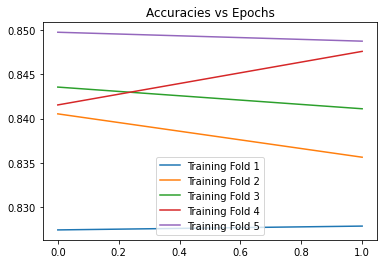

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

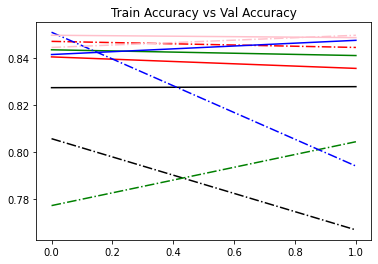

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='pink', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='pink', linestyle = "dashdot")
#plt.legend()
plt.show()

Best Validation Loss: 0.6820
Best Validation Accuracy: 0.7971


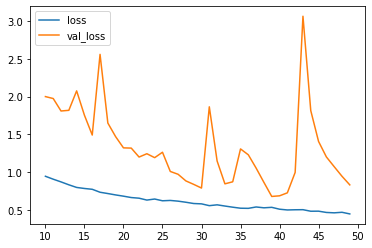

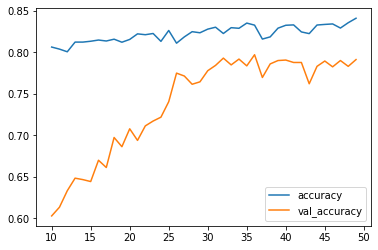

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
history_df.loc[10:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

# MODEL 2

In [ ]:
from tensorflow import keras
#building the detection model
model = keras.Sequential([
    layers.BatchNormalization(input_shape=(87, 1)),
    layers.Conv1D(filters=64,kernel_size=7,activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2) ,
    layers.Dropout(0.3),
    layers.Flatten(), 
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 87, 1)            4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 81, 64)            512       
                                                                 
 batch_normalization_1 (Batc  (None, 81, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                        

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=20000,
    callbacks=[early_stopping],
)

Epoch 1/20000
17/17 [==============================] - 6s 236ms/step - loss: 0.7863 - binary_accuracy: 0.6289 - val_loss: 0.7072 - val_binary_accuracy: 0.5000
Epoch 2/20000
17/17 [==============================] - 4s 214ms/step - loss: 0.6955 - binary_accuracy: 0.6779 - val_loss: 0.6934 - val_binary_accuracy: 0.5175
Epoch 3/20000
17/17 [==============================] - 4s 212ms/step - loss: 0.6533 - binary_accuracy: 0.6982 - val_loss: 0.6900 - val_binary_accuracy: 0.5679
Epoch 4/20000
17/17 [==============================] - 4s 211ms/step - loss: 0.6458 - binary_accuracy: 0.7028 - val_loss: 0.6911 - val_binary_accuracy: 0.6001
Epoch 5/20000
17/17 [==============================] - 4s 228ms/step - loss: 0.6199 - binary_accuracy: 0.7186 - val_loss: 0.6851 - val_binary_accuracy: 0.6260
Epoch 6/20000
17/17 [==============================] - 4s 211ms/step - loss: 0.6187 - binary_accuracy: 0.7206 - val_loss: 0.6878 - val_binary_accuracy: 0.5227
Epoch 7/20000
17/17 [=========================

Best Validation Loss: 0.4046
Best Validation Accuracy: 0.8265


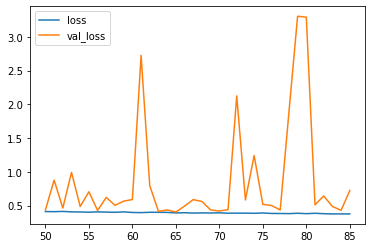

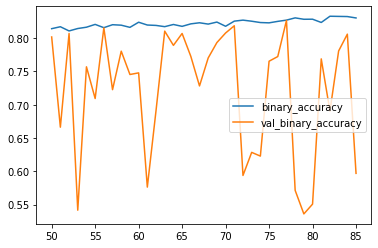

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 50
history_df.loc[50:, ['loss', 'val_loss']].plot()
history_df.loc[50:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

# MODEL 3

In [ ]:
from tensorflow.keras.models import Sequential
class CNN(Sequential):
    def __init__(self,nfilters,sfilters):
        super().__init__()
        tf.random.set_seed(0)
        self.add(layers.Conv2D(nfilters[0],kernel_size=(sfilters[0],sfilters[0]),padding='same',activation='relu',input_shape=(112,92,1)))
        self.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        self.add(layers.Conv2D(nfilters[1],kernel_size=(sfilters[1],sfilters[1]),padding='same',activation='relu'))
        self.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        self.add(layers.Conv2D(nfilters[2],kernel_size=(sfilters[2],sfilters[2]),padding='same',activation='relu'))
        self.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        self.add(layers.Flatten())
        self.add(layers.Dropout(0.3))
        self.add(layers.Dense(512,activation='relu'))
        self.add(layers.Dense(40,activation='softmax'))
        self.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
        


In [ ]:
def generate_population(pop_size,nlayers,max_nfilters,max_sfilters):
    #Given the parameters returns randomly generated population
    
    np.random.seed(0)
    pop_nlayers = np.random.randint(1,max_nfilters,(pop_size,nlayers))
    pop_sfilters = np.random.randint(1,max_sfilters,(pop_size,nlayers))
    pop_total = np.concatenate((pop_nlayers,pop_sfilters),axis=1)
    return pop_total

In [ ]:
def fitness(pop,X,Y,epochs):
    pop_acc = []
    for i in range(pop.shape[0]):
        nfilters = pop[i][0:3]
        sfilters = pop[i][3:]
        model = CNN(nfilters,sfilters)
        H = model.fit(X,Y,batch_size=32,epochs=epochs)
        acc = H.history['accuracy']
        pop_acc.append(max(acc))
    return pop_acc

In [ ]:
def select_parents(pop,nparents,fitness):
    parents = np.zeros((nparents,pop.shape[1]))
    for i in range(nparents):
        best = np.argmax(fitness)
        parents[i] = pop[best]
        fitness[best] = -99999
    return parents

In [ ]:
def crossover(parents,pop_size):
    nchild = pop_size - parents.shape[0]
    nparents = parents.shape[0]
    child = np.zeros((nchild,parents.shape[1]))
    for i in range(nchild):
        first = i % nparents
        second = (i+1) % nparents
        child[i,:2] = parents[first][:2]
        child[i,2] = parents[second][2]
        child[i,3:5] = parents[first][3:5]
        child[i,5] = parents[second][5]
    return child

In [ ]:
def mutation(child):
    for i in range(child.shape[0]):
        val = np.random.randint(1,6)
        ind = np.random.randint(1,4) - 1
        if child[i][ind] + val > 100:
            child[i][ind] -= val
        else:
            child[i][ind] += val
        val = np.random.randint(1,4)
        ind = np.random.randint(4,7) - 1
        if child[i][ind] + val > 20:
            child[i][ind] -= val
        else:
            child[i][ind] += val
    return child

In [ ]:
#genetic algorithm
#import cnn
import copy

def population_as_vectors(population_networks):
    population_vectors = []
    for solution in population_networks:
        # Converting the weights of single layer from the current CNN (i.e. solution) to a vector.
        solution_weights_vector = cnn.layers_weights_as_vector(solution)
        # Appending the weights vector of the current layer of a CNN (i.e. solution) to the weights of the previous layers of the same CNN (i.e. solution).
        population_vectors.append(solution_weights_vector)

    return population_vectors

def population_as_matrices(population_networks, population_vectors):
    population_matrices = []
    for solution, solution_weights_vector in zip(population_networks, population_vectors):
        # Converting the weights of single layer from the current CNN (i.e. solution) from a vector to a matrix.
        solution_weights_matrix = cnn.layers_weights_as_matrix(solution, solution_weights_vector)
        # Appending the weights matrix of the current layer of a CNN (i.e. solution) to the weights of the previous layers of the same network (i.e. solution).
        population_matrices.append(solution_weights_matrix)

    return population_matrices

class GACNN:

    def create_population(self):
        population_networks = []
        for solution in range(self.num_solutions):

            network = copy.deepcopy(self.model)

            # Appending the CNN model to the list of population networks.
            population_networks.append(network)

        return population_networks

    def __init__(self, model, num_solutions):

        self.model = model
        self.num_solutions = num_solutions

        # A list holding references to all the solutions (i.e. CNNs) used in the population.
        self.population_networks = self.create_population()

    def update_population_trained_weights(self, population_trained_weights):

        idx = 0
        # Fetches all layers weights matrices for a single solution (i.e. CNN)
        for solution in self.population_networks:
            # Calling the cnn.update_layers_trained_weights() function for updating the 'trained_weights' attribute for all layers in the current solution (i.e. CNN).
            cnn.update_layers_trained_weights(model=solution, 
                                              final_weights=population_trained_weights[idx])
            idx = idx + 1

In [ ]:
pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.5 MB/s 


In [ ]:
import numpy
import pygad.cnn
import pygad.gacnn
import pygad



In [ ]:
GACNN_instance = pygad.gacnn.GACNN(model=model_1,num_solutions=4)
population_vectors = pygad.gacnn.population_as_vectors(population_networks=GACNN_instance.population_networks)

initial_population = population_vectors.copy()

num_parents_mating = 2 # Number of solutions to be selected as parents in the mating pool.

num_generations = 10 # Number of generations.

mutation_percent_genes = 0.1 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.

parent_selection_type = "sss" # Type of parent selection.

crossover_type = "single_point" # Type of the crossover operator.

mutation_type = "random" # Type of the mutation operator.

keep_parents = -1

AttributeError: ignored

In [ ]:
n_folds=3
epochs=20
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")